# Jonathan Halverson
# Thursday, February 2, 2017
# Network analysis of US flights

We have US flight data from April 2014 and a list of all the airports in the world along with their coordinates. The idea here is to identify the top 50 most active airports in the US then make a network out of them and do a brief analysis such as computing shortest path and degree of centrality.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We begin by reading in the airport data:

In [2]:
# airport coordinates taking from http://openflights.org/data.html
columns = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'Type', 'Source']
coords = pd.read_csv('airports.csv', header=None, names=columns)
coords.head(3)

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,Type,Source
0,1,Goroka,Goroka,Papua New Guinea,GKA,AYGA,-6.081689,145.391881,5282,10.0,U,Pacific/Port_Moresby
1,2,Madang,Madang,Papua New Guinea,MAG,AYMD,-5.207083,145.788700,20,10.0,U,Pacific/Port_Moresby
2,3,Mount Hagen,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789,144.295861,5388,10.0,U,Pacific/Port_Moresby


In [3]:
coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8107 entries, 0 to 8106
Data columns (total 12 columns):
AirportID    8107 non-null int64
Name         8107 non-null object
City         8107 non-null object
Country      8107 non-null object
IATA         5880 non-null object
ICAO         8043 non-null object
Latitude     8107 non-null float64
Longitude    8107 non-null float64
Altitude     8107 non-null int64
Timezone     8107 non-null float64
Type         8107 non-null object
Source       8107 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 760.1+ KB


In [4]:
coords[coords.IATA == 'LAX']

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,Type,Source
3385,3484,Los Angeles Intl,Los Angeles,United States,LAX,KLAX,33.942536,-118.408075,126,-8.0,A,America/Los_Angeles


In [5]:
coords[coords.City == 'Beverly']

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,Type,Source
7226,8658,Beverly Municipal Airport,Beverly,United States,BVY,KBVY,42.584141,-70.916144,107,-5.0,A,America/New_York


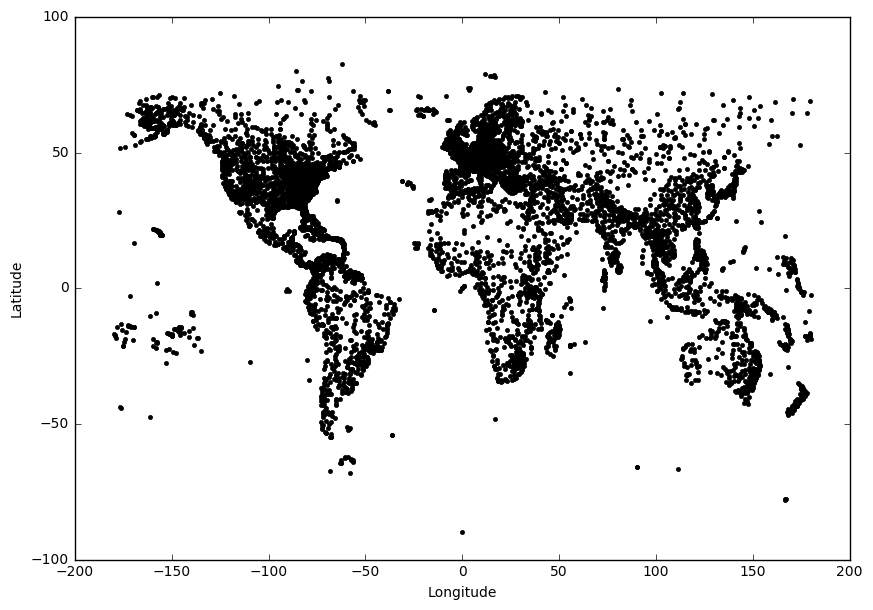

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(coords.Longitude, coords.Latitude, 'k.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Let's focus just on airports in the US:

In [7]:
coords_us = coords[coords.Country == 'United States']

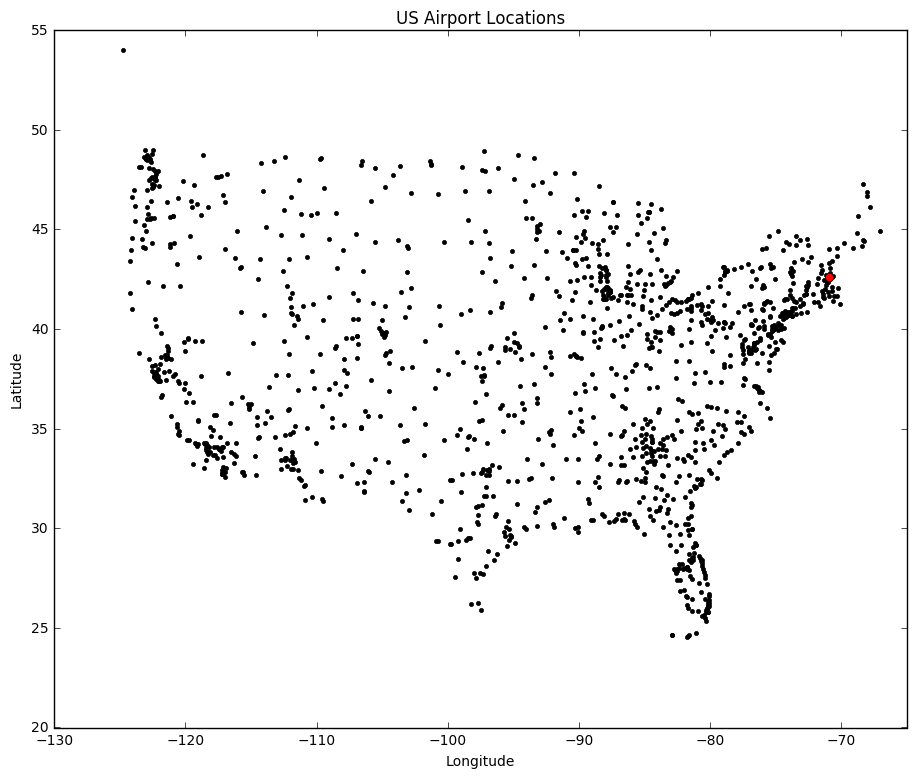

In [8]:
fig, ax = plt.subplots(figsize=(11, 9))
plt.plot(coords_us.Longitude, coords_us.Latitude, 'k.')
plt.plot([-70.916144], [42.584141], 'ro')
plt.xlim(-130, -65)
plt.ylim(20, 55)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('US Airport Locations')

### Load flight data

In [9]:
# flight data is for April 2014
columns = ['flight_date', 'airline_id', 'flight_num', 'origin', 'destination', 'departure_time', 'departure_delay', 'arrival_time', 'arrival_delay', 'air_time', 'distance']
flights = pd.read_csv('../hadoop/ontime/flights.csv', parse_dates=[0], header=None, names=columns)
flights.head(3)

,flight_date,airline_id,flight_num,origin,destination,departure_time,departure_delay,arrival_time,arrival_delay,air_time,distance
0,2014-04-01,19805,1,JFK,LAX,854,-6.0,1217,2.0,355.0,2475.0
1,2014-04-01,19805,2,LAX,JFK,944,14.0,1736,-29.0,269.0,2475.0
2,2014-04-01,19805,3,JFK,LAX,1224,-6.0,1614,39.0,371.0,2475.0


In [10]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476881 entries, 0 to 476880
Data columns (total 11 columns):
flight_date        476881 non-null datetime64[ns]
airline_id         476881 non-null int64
flight_num         476881 non-null int64
origin             476881 non-null object
destination        476881 non-null object
departure_time     476881 non-null int64
departure_delay    476881 non-null float64
arrival_time       476881 non-null int64
arrival_delay      476881 non-null float64
air_time           476881 non-null float64
distance           476881 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 40.0+ MB


In [11]:
flights.flight_date.min(), flights.flight_date.max()

(Timestamp('2014-04-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

Join the two data sets on the airport code so that we can relate the coordinates of the airports to the flights:

In [12]:
df = pd.merge(flights, coords_us, how='inner', left_on='origin', right_on='IATA')
df.shape

(474023, 23)

Find the top 50 airports in the US by number of origins (remove the airport in Hawaii):

In [13]:
top50 = set(df.origin.value_counts()[:51].index.tolist())
top50.remove('HNL')
airports_top50 = coords_us[coords_us.IATA.isin(top50)]

Plot the 50 most used airports in the US:

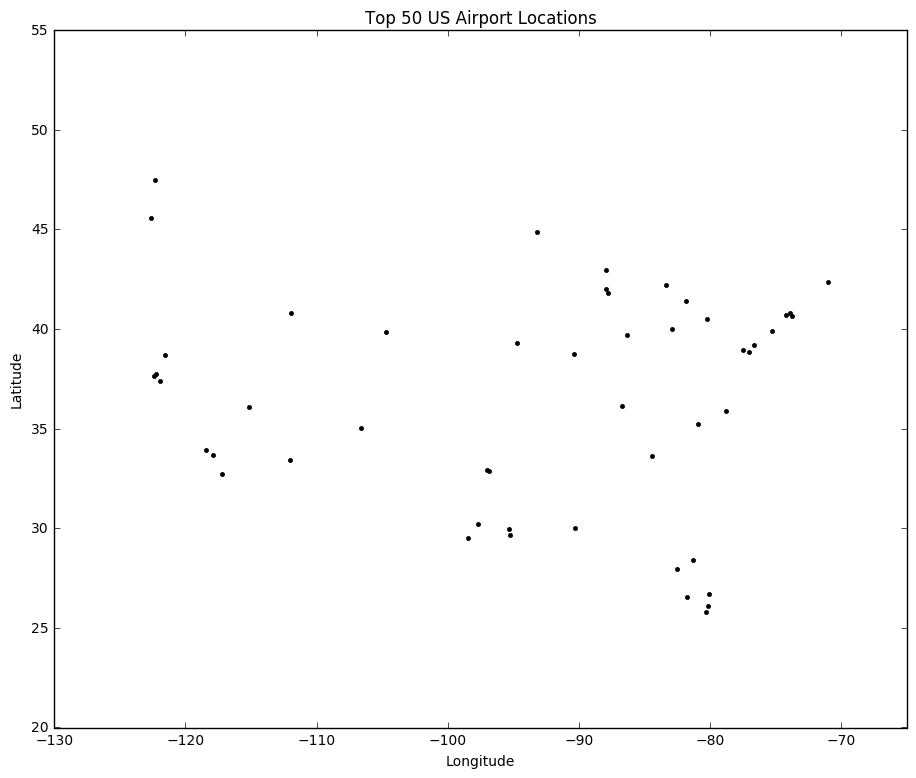

In [14]:
fig, ax = plt.subplots(figsize=(11, 9))
plt.plot(airports_top50.Longitude, airports_top50.Latitude, 'k.')
plt.xlim(-130, -65)
plt.ylim(20, 55)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Top 50 US Airport Locations')

Filter the combined data set:

In [15]:
df50 = df[(df.origin.isin(top50)) & (df.destination.isin(top50))]

After the merge we have coordinates of all the airports.

In [16]:
df50.head(3).transpose()

,0,1,2
flight_date,2014-04-01 00:00:00,2014-04-01 00:00:00,2014-04-01 00:00:00
airline_id,19805,19805,19805
flight_num,1,3,9
origin,JFK,JFK,JFK
destination,LAX,LAX,LAX
departure_time,854,1224,648
departure_delay,-6,-6,-7
arrival_time,1217,1614,1029
arrival_delay,2,39,19
air_time,355,371,365


### Start network analysis

In [17]:
import networkx as nx

In [18]:
def make_node(x):
    return (x['IATA'], {'pos':(x['Longitude'], x['Latitude']), 'name':x['Name']})
airports_top50['nodes'] = airports_top50.apply(make_node, axis=1)

/Users/jhalverson/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [19]:
airports_top50.nodes[:5]

3349    (BOS, {u'pos': (-71.005181, 42.364347), u'name...
3354    (OAK, {u'pos': (-122.220722, 37.721278), u'nam...
3359    (MCI, {u'pos': (-94.713905, 39.297606), u'name...
3363    (PHX, {u'pos': (-112.011583, 33.434278), u'nam...
3370    (SFO, {u'pos': (-122.374889, 37.618972), u'nam...
Name: nodes, dtype: object

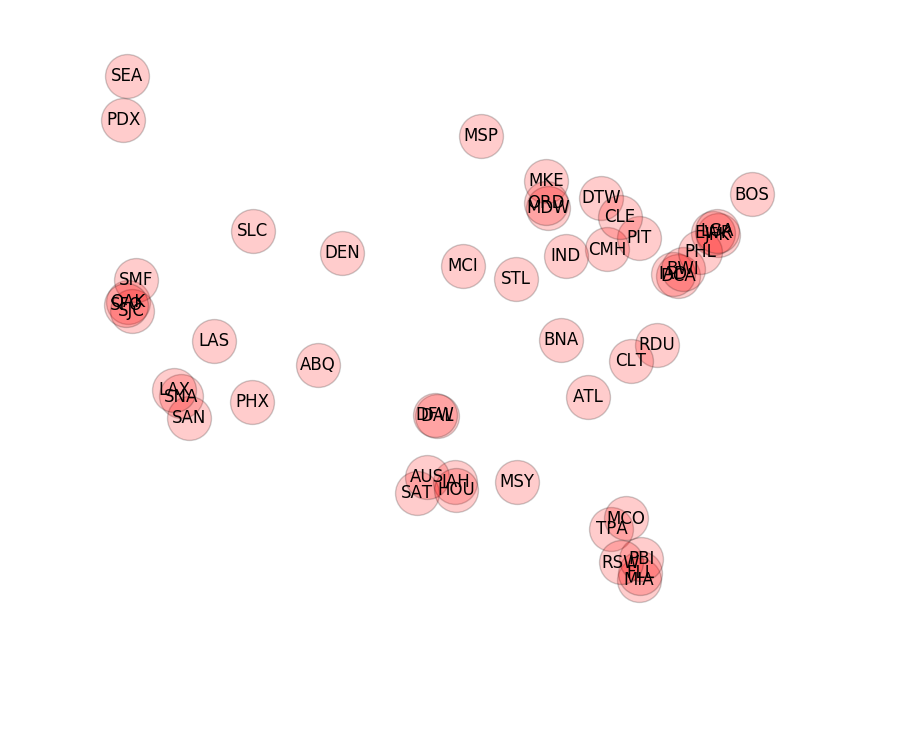

In [20]:
H = nx.DiGraph()
H.add_nodes_from(airports_top50.nodes.values)
pos = nx.get_node_attributes(H, 'pos')
fig, ax = plt.subplots(figsize=(11, 9))
nx.draw(H, pos, node_size=1000, edge_color='b', alpha=0.2, font_size=12, with_labels=True)

In [21]:
def f(x):
    return (x['origin'], x['destination'])
df50['edges'] = df50[['origin', 'destination']].apply(f, axis=1)

/Users/jhalverson/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Edges are weighted by their counts:

In [22]:
edge_counts = df50.edges.value_counts()
edge_counts[:5]

(LAX, SFO)    1087
(SFO, LAX)    1074
(JFK, LAX)     986
(LAX, JFK)     981
(LAS, LAX)     967
Name: edges, dtype: int64

In [23]:
edges = []
for codes, count in zip(edge_counts.index, edge_counts.values):
    edges.append((codes[0], codes[1], count))

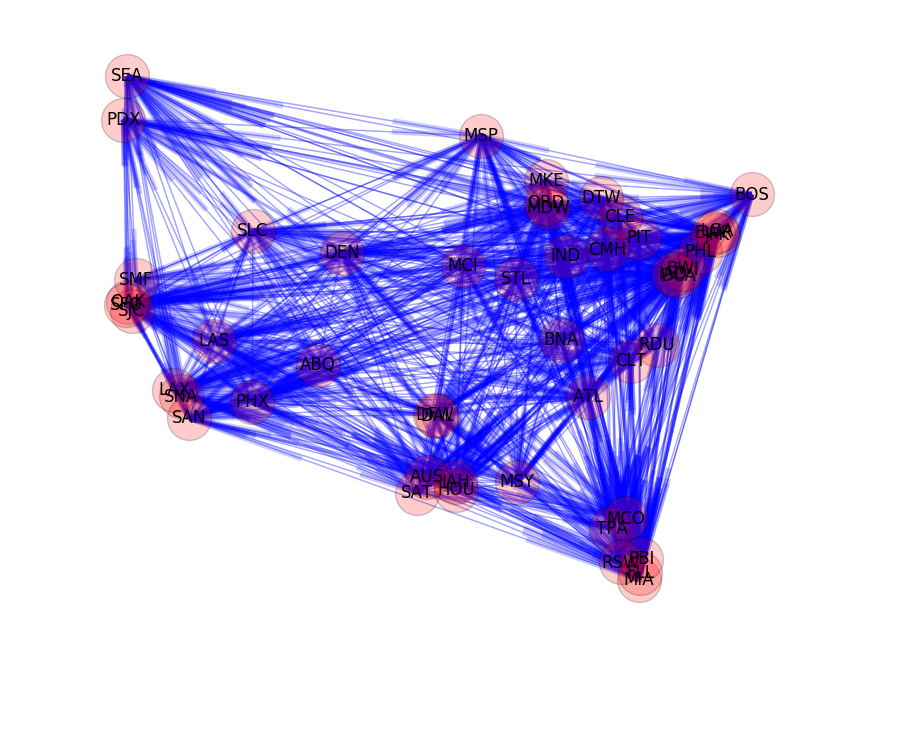

In [24]:
H.add_weighted_edges_from(edges)
fig, ax = plt.subplots(figsize=(11, 9))
nx.draw(H, pos, node_size=1000, edge_color='b', alpha=0.2, font_size=12, with_labels=True)

What are the top ten airports by pagerank?

In [25]:
s_pagerank = pd.Series(nx.pagerank(H))
top10 = s_pagerank.sort_values(ascending=False)[:10]

In [26]:
for code, pr in top10.iteritems():
    print code, H.node[code]['name'], pr

ATL Hartsfield Jackson Atlanta Intl 0.0546632015456
LAX Los Angeles Intl 0.0463454776395
ORD Chicago Ohare Intl 0.0405344485733
DFW Dallas Fort Worth Intl 0.0387152112278
DEN Denver Intl 0.0364492693474
PHX Phoenix Sky Harbor Intl 0.0345404748635
SFO San Francisco Intl 0.0324779933211
LAS Mc Carran Intl 0.0304651580264
BOS General Edward Lawrence Logan Intl 0.0280316375019
IAH George Bush Intercontinental 0.0273397191826


In [27]:
s_flights = df50.origin.value_counts() + df50.destination.value_counts()
s_flights = s_flights / s_flights.sum()

In [28]:
ss = pd.DataFrame({'pagerank':s_pagerank, 'flights':s_flights})

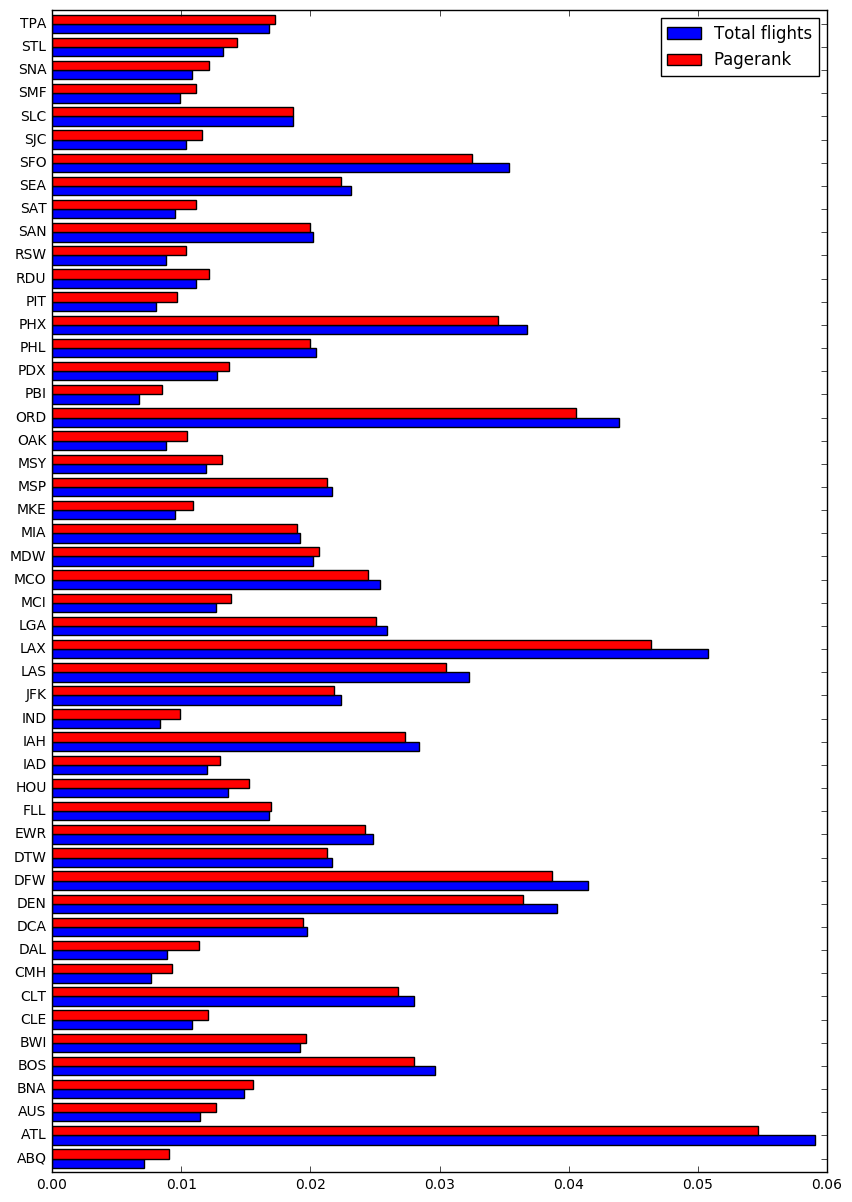

In [29]:
fig, ax = plt.subplots(figsize=(10, 15))

ind = np.arange(ss.shape[0])
width = 0.4

ax.barh(ind, ss.flights.values, width, color='b', label='Total flights')
ax.barh(ind + width, ss.pagerank.values, width, color='r', label='Pagerank')
ax.set(yticks=ind + width, yticklabels=ss.index, ylim=[2 * width - 1, ss.shape[0]])
ax.legend()

What is the shortest path between BOS and CMH? Note that we could assign distance to the edges and use this a the weight.

In [30]:
nx.shortest_path(H, 'BOS', 'CMH')

['BOS', 'JFK', 'CMH']

Which airports have the highest degree? Note that maximum value is 98 since Hawaii was eliminated.

In [31]:
pd.Series(nx.degree(H)).sort_values(ascending=False)[:10]

ATL    96
DEN    94
DFW    92
PHX    90
ORD    90
LAX    90
LAS    90
IAH    89
MSP    88
DTW    84
dtype: int64

Which airports are not accessible by Atlanta?

In [32]:
top50 - set(H.neighbors('ATL'))

{'ATL', 'OAK'}

This was confirmed by searching Expedia.

In [33]:
H.number_of_edges(), H.number_of_nodes()

(1684, 50)

In [34]:
H.in_degree('ATL'), H.out_degree('ATL')

(48, 48)